## Import necessary libraries

In [85]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
from statsmodels.tsa.arima_process import arma_generate_sample

## Define a class to generate PCI and PAR time series

In [86]:
class time_series_generator:

    def __init__(self, N, alpha, beta, rho, sigma_M, sigma_R, sigma_X):
        self.N = N
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.sigma_M = sigma_M
        self.sigma_R = sigma_R
        self.sigma_X = sigma_X

    def generate_pci(self):
        '''
        Generate two partially cointegrated time series of length N with given parameters, such that:
            - X_2,t = alpha + beta * X_1,t + W_t
            - W_t = M_t + R_t
            - M_t = rho * M_t-1 + eps(M_t)
            - R_t = R_t-1 + eps(R_t)
            - eps(M_t) ∼ NID(0, sigma_M)
            - eps(R_t) ∼ NID(0, sigma_R)

        Parameters:
        N (int): Length of the time series to generate.
        alpha (float): intercept
        beta (float): cointegration coefficient.
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.
        sigma_X (float): white noise variance of X1.

        Returns:
        tuple: A tuple containing two cointegrated time series, X1 and X2, which are numpy.ndarray.
        '''

        ret_X1 = self.sigma_X * np.random.randn(self.N)
        X1 = 100 * np.exp(np.cumsum(ret_X1))  # generate X1
        W, M, R = self._generate_par()  # generate PAR residual
        X2 = self.alpha + self.beta * X1 + W  # compute X2

        return X1, X2, W, M, R

    def _generate_par(self):
        '''
        Generate PAR sample of length N with parameters rho, sigma_M, sigma_R

        Parameters:
        N (int): Length of the time series to generate.
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        numpy.ndarray: A partial autoregressive time series
        '''

        ar_M = [1, -self.rho]
        ar_R = [1, -1]
        ma = [1]

        M = arma_generate_sample(ar_M, ma, self.N, scale=self.sigma_M)
        R = arma_generate_sample(ar_R, ma, self.N, scale=self.sigma_R)
        S = M + R
        return S, M, R

## Define a class to fit a PCI model to two time series

In [87]:
class partial_cointegration:

    def __init__(self, X1, X2):
        self.X1 = X1
        self.X2 = X2

    def fit_pci(self, tol=0.001):
        '''
        Fit partial cointegrated model to time series X1 and X2 such that:
            - X_2,t = alpha + beta * X_1,t + W_t
            - W_t = M_t + R_t
            - M_t = rho * M_t-1 + eps(M_t)
            - R_t = R_t-1 + eps(R_t)
            - eps(M_t) ∼ NID(0, sigma_M)
            - eps(R_t) ∼ NID(0, sigma_R)

        Parameters:
        X1 (numpy.ndarray): time series
        X2 (numpy.ndarray): time series, supposedly partially cointegrated with X1

        Returns:
        alpha (float): estimated value for alpha
        beta (float): estimated value for beta
        rho (float): estimated AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): estimated white noise variance of mean reverting component .
        sigma_R (float): estimated white noise variance of random walk component.
        '''

        # calculate initial guess for beta
        results = self.fit_ols_on_diff()
        beta_i = results

        # calculate initial guess for alpha
        alpha_i = self.X2[0] - beta_i * self.X1[0]

        # calculate residuals W and initial guesses for rho, sigma_M, sigma_R
        W = self.X2 - alpha_i - beta_i * self.X1

        params_i = self.fit_mle(W)

        # perform optimization depending on the mode
        x_i = (alpha_i, beta_i, *params_i)  # initial guess
        res = opt.minimize(self.f_to_min_pci, x_i, args=(self.X1, self.X2), tol=tol)
        alpha, beta, rho, sigma_M, sigma_R = res.x
        ll = -res.fun

        W = self.X2 - alpha - beta * self.X1

        return alpha, beta, rho, sigma_M, sigma_R, ll, W

    def fit_mle(self, W, tol=0.001):
        '''
        fit model using Maximum Likelihood estimation. This is used on the residuals W_t of the linear regression of X1 on X2.

        Parameters:
        X (numpy.ndarray): A partial suspected autoregressive time series

        Returns:
        rho (float): estimated value of rho
        sigma_M (float): estimated value of sigma_M
        sigma_R (float): estimated value of sigma_R
        '''

        estimates = []
        lls = []

        # distribution for random guesses
        rnd_rho = stats.uniform(loc=-1, scale=2)

        # get initial guesses using lagged variances
        x_i = self.lagvar_estimate_par(W)

        # set boundaries
        bounds = ((-1, 1), (0, np.inf), (0, np.inf))

        # function to generate random initial values
        std = np.std(np.diff(W))
        rnd_sigma = stats.norm(loc=std, scale=std / 2)

        def gen_x0():
            return rnd_rho.rvs(), rnd_sigma.rvs(), rnd_sigma.rvs()

        # minimize
        res = opt.minimize(self.f_to_min_par , x0=(x_i), args=(W), bounds=bounds, tol=tol)

        if res.success:
            estimates.append(res.x)
            lls.append(-res.fun)  # save log-likelihood

        # repeat minimization with different (random) initial values
        n_att = 0
        while len(lls) < 10 and n_att < 100:
            n_att += 1
            x0 = gen_x0()
            res = opt.minimize(self.f_to_min_par, x0=(x0), args=(W), bounds=bounds, tol=tol)
            if res.success:
                estimates.append(res.x)
                lls.append(-res.fun)  # save log-likelihood

        try:
            argmax = np.argmax(lls)  # index of the biggest likelihood
            return estimates[argmax]
        except:
            # print('Estimation failed!')
            return len(x0) * [np.nan]  # return nans

    def lagvar_estimate_par(self, W):
        '''
        estimate parameters of partial AR model using lagged variances. used for inital estimation of parameters

        Parameters
        X (numpy.ndarray): A partial autoregressive time series

        Returns:
        rho_lv (float): estimated value for rho
        sigma_M_lv (float): estimated value for sigma_M
        sigma_R_lv (float): estimated value for sigma_R
        '''

        # calculate lagged variances
        v1 = np.var(W[1:] - W[:-1])
        v2 = np.var(W[2:] - W[:-2])
        v3 = np.var(W[3:] - W[:-3])

        # rho
        rho_lv = -(v1 - 2 * v2 + v3) / (2 * v1 - v2)

        # sigma_M
        if (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1) > 0:
            sigma_M_lv = np.sqrt(1 / 2 * (rho_lv + 1) / (rho_lv - 1) * (v2 - 2 * v1))
        else:
            sigma_M_lv = 0

        # sigma_R
        if v2 > 2 * sigma_M_lv ** 2:
            sigma_R_lv = np.sqrt(1 / 2 * (v2 - 2 * sigma_M_lv ** 2))
        else:
            sigma_R_lv = 0

        return rho_lv, sigma_M_lv, sigma_R_lv

    def fit_ols_on_diff(self):
        '''
        Fits an OLS model on the first differences of time series X1 and X2

        Parameters:
        X1 (numpy.ndarray): A time-series
        X2 (numpy.ndarray): A time-series

        Returns:
        results.params[0]: returns the Beta value of our OLS fit
        '''
        ret_X1 = np.diff(self.X1)
        ret_X2 = np.diff(self.X2)

        results = sm.OLS(ret_X2, ret_X1).fit()

        return results.params[0]

    def kalman_estimate(self, W, rho, sigma_M, sigma_R):
        '''
        Calculate estimates of mean-reverting and random walk components.

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        M (numpy.ndarray): An estimate of the mean reverting component of our time series
        R (numpy.ndarray): An estimate of the random walk component of our time series
        eps (numpy.ndarray): Prediction errors for each time step
        '''

        # create arrays for storing both components and prediction errors
        M = np.zeros(len(W))
        R = np.zeros(len(W))
        eps = np.zeros(len(W))

        # set initial state
        if sigma_R == 0:
            M[0] = W[0]
            R[0] = 0
        else:
            M[0] = 0
            R[0] = W[0]

        # calculate Kalman gain
        if sigma_M == 0:
            K_M = 0
            K_R = 1
        elif sigma_R == 0:
            K_M = 1
            K_R = 0
        else:
            sqr = np.sqrt((1 + rho) ** 2 * sigma_R ** 2 + 4 * sigma_M ** 2)
            K_M = 2 * sigma_M ** 2 / (sigma_R * (sqr + rho * sigma_R + sigma_R) + 2 * sigma_M ** 2)
            K_R = 2 * sigma_R / (sqr - rho * sigma_R + sigma_R)

        # calculate estimates
        for i in range(1, len(W)):
            xhat = rho * M[i - 1] + R[i - 1]
            eps[i] = W[i] - xhat
            M[i] = rho * M[i - 1] + eps[i] * K_M
            R[i] = R[i - 1] + eps[i] * K_R

        return M, R, eps

    def calc_log_like(self, W, rho, sigma_M, sigma_R):
        '''
        Compute log likelihood function

        Parameters:
        X (numpy.ndarray): A partial autoregressive time series
        rho (float): AR(1) coefficient / mean reversion coefficient.
        sigma_M (float): white noise variance of mean reverting component .
        sigma_R (float): white noise variance of random walk component.

        Returns:
        ll (float): Value of the log likelihood, a measure of goodness of fit for our model
        '''

        N = len(W)
        _, _, eps = self.kalman_estimate(W, rho, sigma_M, sigma_R)
        ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
                2 * (sigma_M ** 2 + sigma_R ** 2)) * np.sum(eps[1:] ** 2)

        return ll

    def f_to_min_par(self, x_i, W):
        rho, sigma_M, sigma_R = x_i
        '''
        Define the function to minimize for PAR model
        '''
        return -self.calc_log_like(W, rho, sigma_M, sigma_R)

    def f_to_min_pci(self, x_i, X1, X2):
        '''
        Define function to minimize
        '''
        alpha, beta, rho, sigma_M, sigma_R = x_i
        W = X2 - beta * X1 - alpha
        return -self.calc_log_like(W, rho, sigma_M, sigma_R)

## Lets generate and plot two cointegrated time series X1 and X2

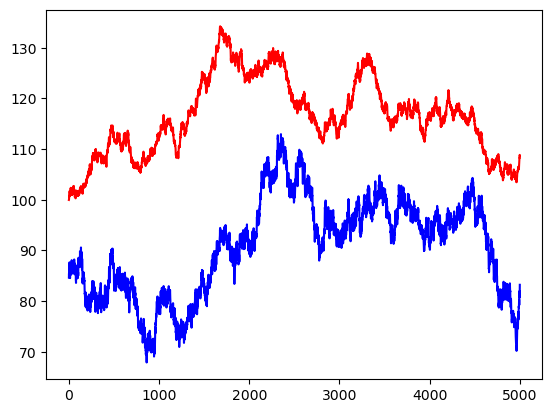

In [95]:
N, alpha, beta, rho, sigma_M, sigma_R, sigma_X = 5000, 10, 0.75, 0.7, 0.6, 0.4, 0.003
params = N, alpha, beta, rho, sigma_M, sigma_R, sigma_X 

generator = time_series_generator(*params)

X1, X2, W, M, R = generator.generate_pci()

plt.figure()
plt.plot(X1, 'r')
plt.plot(X2, 'b')
plt.show()

## Now lets create a partial_cointegration object to fit our time series to a PCI model and estimate its paramaters
We also define W_hat has the residuals, or spread, of our OLS of X1 on X2, as such:

*W_hat = X2 - alpha_hat - beta_hat * X1*

In [96]:
coint = partial_cointegration(X1, X2)
alpha_hat, beta_hat, rho_hat, sigma_M_hat, sigma_R_hat, _, W_hat = coint.fit_pci()

print(f"alpha: {alpha_hat},\nbeta: {beta_hat},\nrho: {rho_hat},\nsigma_M: {sigma_M_hat},\nsigma_R: {sigma_R_hat}")

C:\Users\gagne\AppData\Local\Temp\ipykernel_19152\2509181927.py:226: RuntimeWarning: divide by zero encountered in log
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19152\2509181927.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (
C:\Users\gagne\AppData\Local\Temp\ipykernel_19152\2509181927.py:226: RuntimeWarning: invalid value encountered in scalar subtract
  ll = -(N - 1) / 2 * np.log(2 * np.pi * (sigma_M ** 2 + sigma_R ** 2)) - 1 / (


alpha: 3.931735059418486,
beta: 0.8054802173368852,
rho: 0.6821916953796596,
sigma_M: 0.5925492349760307,
sigma_R: 0.4403303035789633


## As we can see, our estimates aren't far off from the defined values
## Next lets estimate and plot the mean reverting component of our spread using the Kalman filter estimate

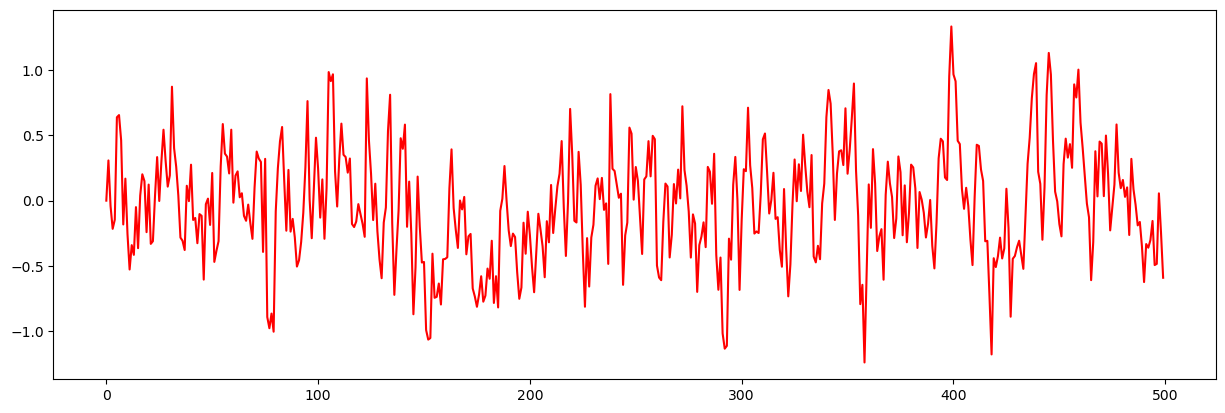

In [97]:
M_hat, R_hat, _ = coint.kalman_estimate(W_hat, rho_hat, sigma_M_hat, sigma_R_hat)

plt.figure().set_figwidth(15)
plt.plot(M_hat[:500], color="r")
plt.show()

## Finally, we can compare our estimated mean-reverting AR(1) process with the actual AR(1) time series simulated by the generator by plotting them both

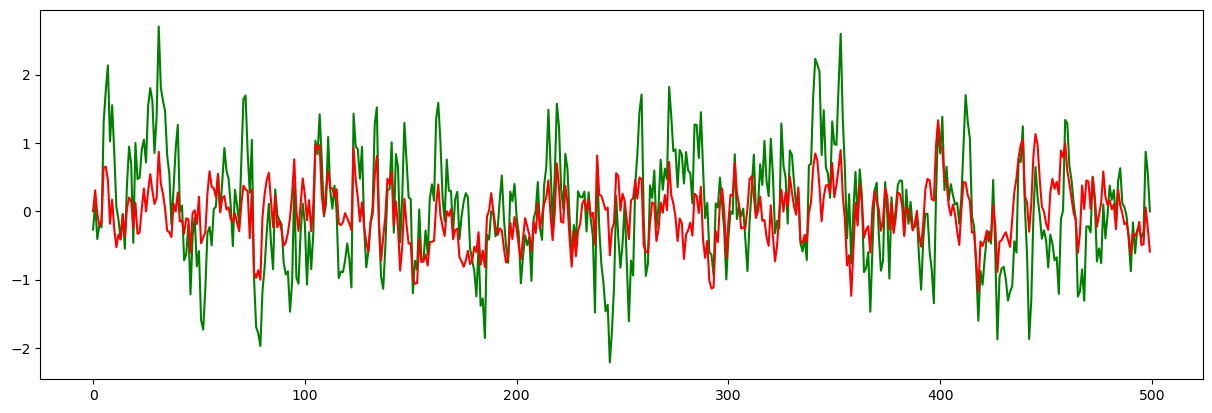

In [100]:
plt.figure().set_figwidth(15)
plt.plot(M[:500], color="g")
plt.plot(M_hat[:500], color="r")
plt.show()


## We can also compare the estimated and real random-walk components

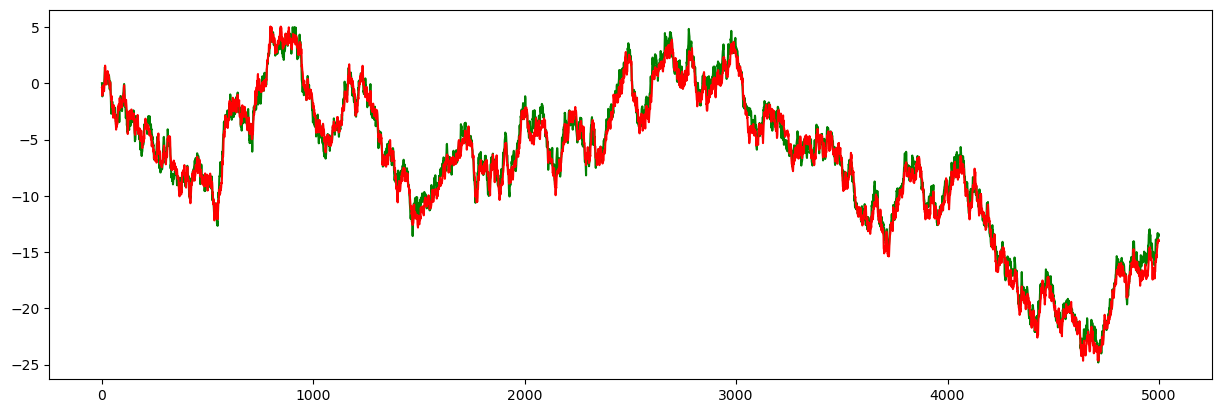

In [92]:
plt.figure().set_figwidth(15)
plt.plot(R[:500], color="g")
plt.plot(R_hat[:500], color="r")
plt.show()


## Finally, by adding M_hat with R_hat, we hope to "rebuild" our spread W_hat, which we can then compare with the actual spread W:

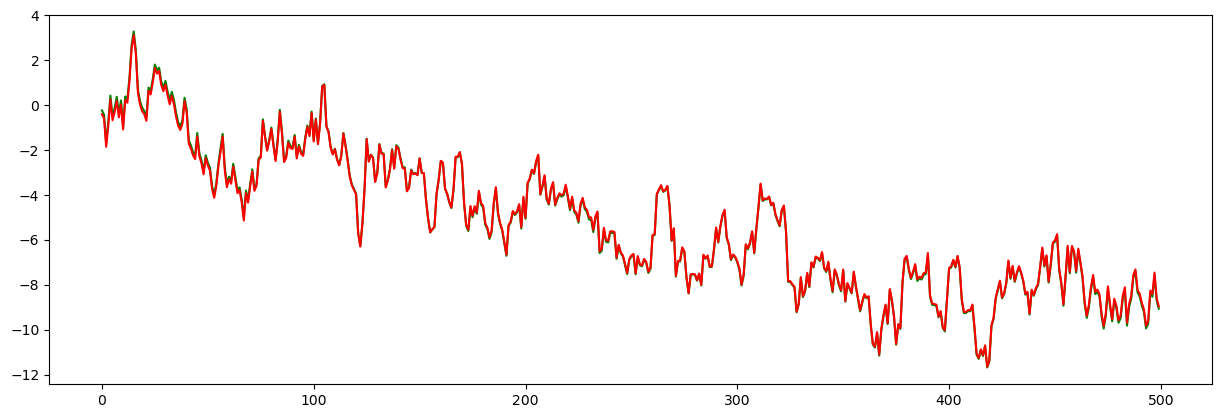

In [93]:
W_hat = M_hat + R_hat

plt.figure().set_figwidth(15)
plt.plot(W[:500], color="g")
plt.plot(W_hat[:500], color="r")
plt.show()